In [29]:
# GAT with complex and normalisation

import torch
import torch_geometric
print('torch version:',torch.__version__)
print('torch version.cuda:',torch.version.cuda)
print('torch geometric version:',torch_geometric.__version__)

torch version: 2.2.1+cu121
torch version.cuda: 12.1
torch geometric version: 2.6.1


In [30]:
from sparticles_hadhad.rewritten_dataset import EventsDataset
from sparticles_hadhad.rewritten_dataset import DEFAULT_EVENT_SUBSETS
from sparticles_hadhad.rewritten_dataset import EVENT_TABLE
import matplotlib.pyplot as plt
from sparticles_hadhad.transforms import MakeHomogeneous
make_homogeneous_trans = MakeHomogeneous()
from sparticles import plot_event_2d
import os
import errno
import numpy as np
from numpy import pi
import yaml

In [108]:
#Code block for processing the raw data from the h5 file. These are the h5 files that cut events with pT < 20GeV.
LAMBDA_VAL = 100 #100, 240, 300
lambda_values = 100, 240, 300
lambda_signal = (72380, 74169, 65152)

if LAMBDA_VAL in lambda_values:
    index = lambda_values.index(LAMBDA_VAL)
    selected_signal = lambda_signal[index]

sig_no = selected_signal #max lambda100 = 72380, lambda240 = 74169, lambda300 = 65152
ttb_no = 213475 #max = 213475
vjets_no = 0

if sig_no == ttb_no:
    stats_string = 'balanced_stats'
else:
    stats_string = f'sig_{sig_no}_ttb_{ttb_no}'
    
processed_file = f"/hepstore/{os.environ['USER']}/fcc_hh_data_hadhad_84TeV/processed/events_signal_{sig_no}_ttbar_{ttb_no}_vjets_{vjets_no}.pt"

def remove_processed(filename):
    try:
        os.remove(filename)
    except OSError as e: 
        if e.errno != errno.ENOENT: 
            raise

#remove_processed(processed_file)

with open('means.yaml' ) as f:
    mean_list_loaded = yaml.load(f, Loader = yaml.Loader)

with open('std.yaml' ) as g:
    std_list_loaded = yaml.load(g, Loader = yaml.Loader)



graphs = EventsDataset(
    root= f'/hepstore/{os.environ["USER"]}/fcc_hh_data_hadhad_84TeV',
    url='https://cernbox.cern.ch/s/SpsIy2kRzVZtwnn/download/',
    delete_raw_archive=False,
    add_edge_index=True,
    event_subsets={'signal': sig_no, 'ttbar': ttb_no, 'vjets': vjets_no}, #For the FCC, only ttbar events are used, but the h5 file for background is saved and taken from the 'singletop' file. 
    transform=MakeHomogeneous(),
    download_type=2,
    signal_filename=f'pwp8_pp_hh_lambda{LAMBDA_VAL}_5f_80TeV_SA_hhbbtata.h5', # Specify the signal filename here
    bb_features = {"m_bb": True, "dEta_bb": False, "dPhi_bb": False, "dR_bb": True},
    tt_features = {"m_tt": True, "dEta_tt": False, "dPhi_tt": False, "dR_tt": True, "dpT_tt": True},
    other_features = {"m_T": True, "C_met": True, "m_HH": True, "dPhi_HH": True},
    loaded_means = mean_list_loaded, # for the standisation to be the same when applying the kappa_lambda = 1 to the other signal samples.
    loaded_stds = std_list_loaded
)
  
save_bool = graphs.feature_string()

In [102]:
# 

# with open('means.yaml', 'w' ) as f:
#     mean_list = graphs.mean_values.tolist()
#     yaml.dump(mean_list,f)

# with open('std.yaml', 'w' ) as f:
#     std_list = graphs.std_values.tolist()
#     yaml.dump(std_list,f)


In [4]:
print(graphs[0].data_norm)

tensor([[ 1.7973e+00,  0.0000e+00,  2.1334e+00,  0.0000e+00, -9.0628e-02,
          0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,
          0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
          1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,
          0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00],
        [-6.6148e-01,  0.0000e+00,  1.6870e+00,  0.0000e+00, -1.0448e-02,
          0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,
          0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
          1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,
          0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00],
        [ 7.7660e-01,  0.0000e+00,  2.3840e-01,  0.0000e+00,  1.5494e+00,
          0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,
          0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
          1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  

In [109]:
# using GATv2Conv
from torch_geometric.nn import GATv2Conv, global_mean_pool
import torch

MANUAL_SEED = 1234 

class GAT(torch.nn.Module):
    def __init__(self, input_channels, hidden_channels, num_classes):
        super(GAT, self).__init__()
        torch.manual_seed(MANUAL_SEED)
        self.conv1 = GATv2Conv(input_channels, hidden_channels)
        self.activation1 = torch.nn.ReLU() 
        self.conv2 = GATv2Conv(hidden_channels, hidden_channels)
        self.activation2 = torch.nn.ReLU() 
        self.conv3 = GATv2Conv(hidden_channels, hidden_channels)
        self.aggregate = global_mean_pool
        self.head = torch.nn.Linear(hidden_channels, num_classes)


    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = self.activation1(x)
        x = self.conv2(x, edge_index)
        x = self.activation2(x)
        x = self.conv3(x, edge_index)
        x = self.aggregate(x, batch)
        x = self.head(x)
        return x

In [110]:
from torch.utils.data import Subset
from torch_geometric.loader import DataLoader
from sklearn.model_selection import train_test_split
import time

# 5 fold 
# fold |  A        | B        | C        | D        | E        |
#  1   |  Train    | Train    | Train    | Validate | Test     |
#  2   |  Test     | Train    | Train    | Train    | Validate |
#  3   |  Validate | Test     | Train    | Train    | Train    |
#  4   |  Train    | Validate | Test     | Train    | Train    |
#  4   |  Train    | Train    | Validate | Test     | Train    |


also_graphs = graphs

setA_graphs = also_graphs[0::5] 
setB_graphs = also_graphs[1::5] 
setC_graphs = also_graphs[2::5] 
setD_graphs = also_graphs[3::5]
setE_graphs = also_graphs[4::5]

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
model = GAT(input_channels=graphs[0].data_norm.shape[1], hidden_channels=50, num_classes=1) #num_classes denotes the output, we have output of dimension 1 in our case.
model.to(device)

def set_shift(all_graphs): 
    all_graphs = all_graphs[-1:] + all_graphs[:-1]
    return all_graphs


In [111]:
EPOCH_NUMBER = 100

In [112]:
import torch
import torch.nn.functional as F
import time
from torchmetrics import Accuracy
from tqdm import tqdm # for nice bar

sig_weight = ttb_no/sig_no
start = time.time()

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-7, weight_decay=1e-5) 
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr = 5e-4, steps_per_epoch=len(train_loader), epochs=EPOCH_NUMBER, 
# pct_start = 0.01, div_factor = 5000,final_div_factor = 1e-2)
print(model)                                                                  
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
epoch_loss = []
epoch_acc = []
auc_list = []

os.makedirs('Epochs/fixed_kFolds/CarlFold/84TeV', exist_ok=True) 

compute_acc = Accuracy(task='binary')
compute_acc.to(device)

all_graphs = setA_graphs, setB_graphs, setC_graphs, setD_graphs, setE_graphs

for fold in range(len(all_graphs)):
    print('============================')
    print(f'           FOLD {fold}           ')
    print('============================')
    train_graphs = all_graphs[0] + all_graphs[1] + all_graphs[2]
    val_graphs = all_graphs[3]
    #test_graphs = all_graphs[2]
    
    train_loader = DataLoader(train_graphs, batch_size=500, shuffle=True) 
    val_loader = DataLoader(val_graphs, batch_size=500, shuffle=False)
    #test_loader = DataLoader(test_graphs, batch_size=500, shuffle=False)
    model = GAT(input_channels=graphs[0].data_norm.shape[1], hidden_channels=50, num_classes=1) #num_classes denotes the output, we have output of dimension 1 in our case.
    model.to(device)
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-7, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr = 5e-4, steps_per_epoch=len(train_loader), epochs=EPOCH_NUMBER, #max_lr=5e-4, 
                                                pct_start = 0.01, div_factor = 5000,final_div_factor = 1e-2)
    for epoch in range(EPOCH_NUMBER):
        print(f'Training epoch: {epoch}')
        epoch_start = time.time()
        for batch in tqdm(train_loader, leave=False):
            batch = batch.to(device)
            optimizer.zero_grad() #resets the gradient 
            out = model(batch.data_norm.float(), batch.edge_index, batch.batch) 
            loss = F.binary_cross_entropy_with_logits(out.squeeze(), batch.y.float(), pos_weight=torch.tensor(sig_weight))
            loss.backward()
            train_losses.append(loss.detach().item())
            # acc = compute_acc(out.detach().squeeze(), batch.y.float())
            acc = compute_acc(out.squeeze(), batch.y.float())
            
            train_accuracies.append(acc.cpu().detach())
            optimizer.step()
            scheduler.step()
        
        print(f'Validation epoch: {epoch}')
        with torch.no_grad():
            out = np.empty(0)
            # print('out:', out)
            valy = np.empty(0)
            for batch in tqdm(val_loader, leave=False):
              batch.to(device)
              x =  model(batch.data_norm.float(), batch.edge_index, batch.batch).squeeze()
              # print(x.shape)
              out = np.concatenate((out, x.cpu().detach().numpy()))
              valy = np.concatenate((valy, batch.y.float().cpu().detach().numpy()))
            #print(valy.shape)
            loss = F.binary_cross_entropy_with_logits(torch.tensor(out), torch.tensor(valy), pos_weight=torch.tensor(sig_weight))
            val_losses.append(loss.detach().item())
            val_accuracies.append(compute_acc(torch.tensor(out), torch.tensor(valy)).cpu().detach())
        model.cpu()
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_losses': train_losses,
            'val_losses': val_losses,
            'train_accuracies': train_accuracies,
            'val_accuracies': val_accuracies
        }, f'Epochs/fixed_kFolds/CarlFold/84TeV/CarlFold_{fold}_{LAMBDA_VAL}_epoch_{epoch}.pth')
        print(f'Epoch {epoch:>3} Saved.')
        model.to(device)
        if epoch % 1 == 0:
            now = time.time()
            print(f'Epoch {epoch:>3} | Loss: {loss:.2f} | Acc: {acc*100:.2f}% | Epoch Time: {(now-epoch_start)/60:.2f} mins | Total Time: {(now-start)/60:.2f} mins')
            
            epoch_loss.append(loss)
            epoch_acc.append(acc*100)
        all_graphs = set_shift(all_graphs)

print('')
end = time.time()
print(f'Time taken to run cell: {(end - start)/60} mins :)')

GAT(
  (conv1): GATv2Conv(24, 50, heads=1)
  (activation1): ReLU()
  (conv2): GATv2Conv(50, 50, heads=1)
  (activation2): ReLU()
  (conv3): GATv2Conv(50, 50, heads=1)
  (head): Linear(in_features=50, out_features=1, bias=True)
)
           FOLD 0           
Training epoch: 0


KeyboardInterrupt: 

In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import numpy as np

# model.to('cpu')

fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=("Train loss (batches)", "Validation loss (epochs)", "Train acc (batches)", "Validation acc (epochs)"))

fig.add_trace(go.Scatter(x=np.arange(len(train_losses)), y=train_losses),   row=1, col=1)

fig.add_trace(go.Scatter(x=np.arange(len(val_losses)), y=val_losses), row=1, col=2)

fig.add_trace(go.Scatter(x=np.arange(len(train_accuracies)), y=train_accuracies), row=2, col=1)

fig.add_trace(go.Scatter(x=np.arange(len(val_accuracies)), y=val_accuracies), row=2, col=2)

fig.update_layout(height=800, width=1000, title=f'Training results, {epoch+1} epochs', showlegend=False)

fig.show()


In [148]:
LEGEND_SIZE = 8
SMALL_SIZE = 12
MEDIUM_SIZE = 20
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)

In [ ]:
import torch
import torch.nn.functional as F
import time
from torchmetrics import Accuracy
from tqdm import tqdm # for nice bar
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import os

os.makedirs('Saved Figures/GATComplexNorm/kFold/CarlFold/84TeV', exist_ok=True) 
sig_weight = ttb_no/sig_no
compute_acc = Accuracy(task='binary')
compute_acc.to(device)

test_losses = []
test_accuracies = []
all_true_labels = []
all_predicted_probs = []
all_signal_probs = []
all_background_probs = []



def import_snapshot(model, snap_name):
    checkpoint = torch.load(snap_name)
    
    model.load_state_dict(checkpoint['model_state_dict'])
    val_losses = np.array(checkpoint['val_losses'])
    model.eval()

    return model, val_losses

LAST_EPOCH = 99

all_graphs = setA_graphs, setB_graphs, setC_graphs, setD_graphs, setE_graphs

for fold in range(len(all_graphs)):
    model.to(device)
    test_graphs = all_graphs[4] # selects the last value of all splits
    test_loader = DataLoader(test_graphs, batch_size=500, shuffle=False)
    print(f'Reading Snapshot for Fold {fold}...')
    model, _ = import_snapshot(model, f"Epochs/fixed_kFolds/CarlFold/84TeV/CarlFold_{fold}_100_epoch_{LAST_EPOCH}.pth")
    print('Done!')
    print(f'Test on Fold {fold}')
    with torch.no_grad():
        out = np.empty(0)
        testy = np.empty(0)
        for batch in tqdm(test_loader, leave=False):
            batch.to(device)
            x =  model(batch.data_norm.float(), batch.edge_index, batch.batch).squeeze()
            out = np.concatenate((out, x.cpu().detach().numpy()))
            testy = np.concatenate((testy, batch.y.float().cpu().detach().numpy()))
        loss = F.binary_cross_entropy_with_logits(torch.tensor(out), torch.tensor(testy), pos_weight=torch.tensor(sig_weight))
        test_losses.append(loss.detach().item())
        test_accuracies.append(compute_acc(torch.tensor(out), torch.tensor(testy)).cpu().detach())   
    # ROC curve plotting
    print('Plotting ROC Curve...')
    model.cpu() # Move model to cpu
    # Concatenate true labels and predicted logits
    true_labels = torch.cat([batch.y for batch in test_loader.dataset]).numpy()
    all_true_labels = np.concatenate((all_true_labels, true_labels))
    predicted_logits = torch.cat([model(batch.data_norm.float(), batch.edge_index, batch.batch).detach().squeeze() for batch in test_loader]).numpy()
    # Convert logits to probabilities using sigmoid function
    predicted_probs = torch.sigmoid(torch.tensor(predicted_logits)).numpy()
    all_predicted_probs = np.concatenate((all_predicted_probs, predicted_probs))
    
    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(true_labels, predicted_probs)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
    
    plt.xlabel('Background Efficiency',fontsize="x-large")
    plt.ylabel('Signal Efficiency',fontsize="x-large")
    plt.title(f'GAT Model, kFold: {fold}, {EPOCH_NUMBER} Epochs, pos_weights = {sig_no} / {ttb_no} $\simeq$ {sig_weight:.2f}')
    plt.legend(loc='lower right',fontsize="x-large")
    plt.savefig(f'Saved Figures/GATComplexNorm/kFold/CarlFold/84TeV/RoCCurve_GAT_{LAMBDA_VAL}_{save_bool}norm_{stats_string}_{EPOCH_NUMBER}epochs_kFold{fold}.png')
    plt.savefig(f'Saved Figures/GATComplexNorm/kFold/CarlFold/84TeV/RoCCurve_GAT_{LAMBDA_VAL}_{save_bool}norm_{stats_string}_{EPOCH_NUMBER}epochs_kFold{fold}.pdf')
    plt.show()
    # Score distribution plotting
    # Filter predictions based on true labels (signal and background)
    print('Plotting Score...')
    signal_indices = true_labels == 1
    background_indices = true_labels == 0
    
    signal_probs = predicted_probs[signal_indices]
    all_signal_probs = np.concatenate((all_signal_probs, signal_probs))
    background_probs = predicted_probs[background_indices]
    all_background_probs = np.concatenate((all_background_probs, background_probs))
    
    # Plotting
    plt.figure(figsize=(10, 8))
    plt.subplot(2,1,1)
    plt.yscale('linear')
    plt.hist(signal_probs, bins=100, alpha=0.7, label='Signal', density=True, color='#ea6aea')
    plt.hist(background_probs, bins=100, alpha=0.7, label='Background', density=True, color='#93f393')
    plt.xlim(0,1)
    plt.subplot(2,1,2)
    plt.yscale('log')
    plt.hist(signal_probs, bins=100, color='#ea6aea', alpha=0.7, label='Signal', density=True)
    plt.hist(background_probs, bins=100, color='#93f393', alpha=0.7, label='Background', density=True)
    
    plt.title(f'GAT Output Dist. on Test Dataset, kFold: {fold}, {EPOCH_NUMBER} Epochs, pos_weights = {sig_no} / {ttb_no} $\simeq$ {sig_weight:.2f}',fontsize="large")
    plt.xlabel('Score',fontsize="x-large")
    plt.ylabel('Density',fontsize="x-large")
    plt.xlim(0,1)
    plt.legend()
    plt.tight_layout()
    #plt.savefig('ModelOutputDistDefault.png')
    plt.savefig(f'Saved Figures/GATComplexNorm/kFold/CarlFold/84TeV/ModelOutputDist_GAT_{LAMBDA_VAL}_{save_bool}norm_{stats_string}_{EPOCH_NUMBER}epochs_kFold{fold}.png')
    plt.savefig(f'Saved Figures/GATComplexNorm/kFold/CarlFold/84TeV/ModelOutputDist_GAT_{LAMBDA_VAL}_{save_bool}norm_{stats_string}_{EPOCH_NUMBER}epochs_kFold{fold}.pdf')
    plt.show()   
    all_graphs = set_shift(all_graphs) #shifts the slices by one

Plotting Combined kFold ROC Curve...


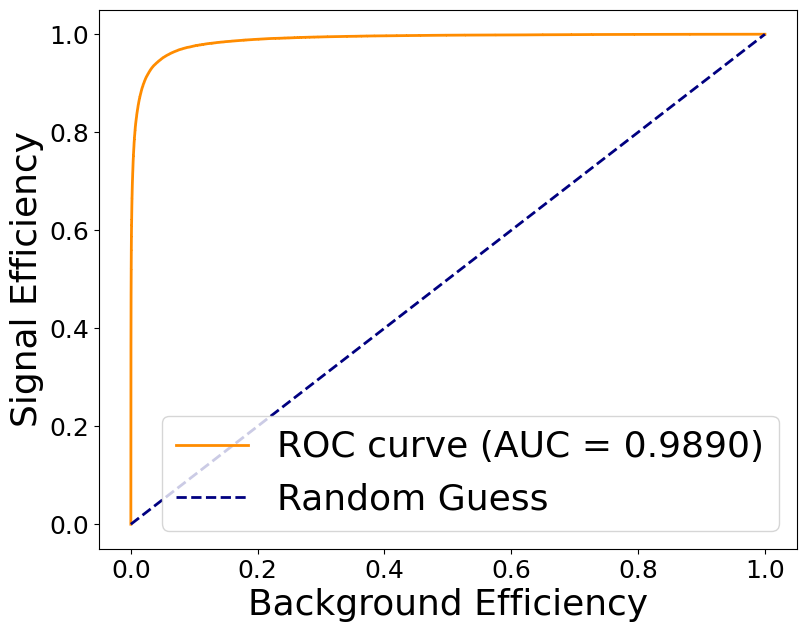

Plotting Combined kFold Score...


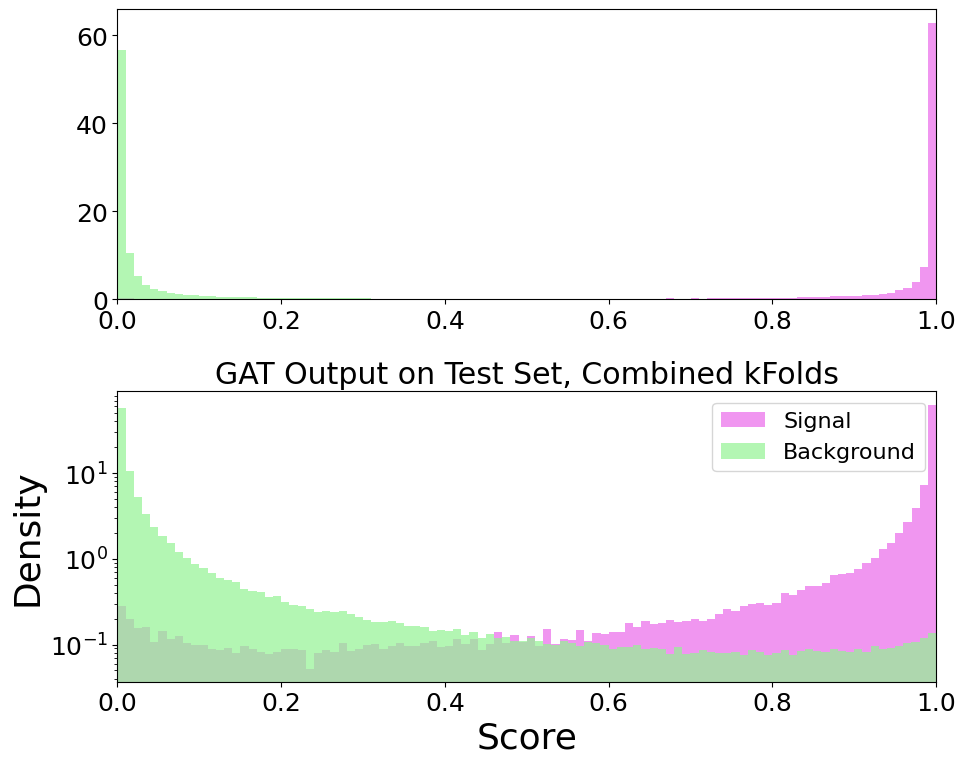

In [144]:
# Combined kfolds
print("Plotting Combined kFold ROC Curve...")
# ROC Curve Plotting
# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(all_true_labels, all_predicted_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(9, 7))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')

plt.xlabel('Background Efficiency',fontsize="x-large")
plt.ylabel('Signal Efficiency',fontsize="x-large")

plt.legend(loc='lower right',fontsize=26)
plt.savefig(f'Saved Figures/GATComplexNorm/kFold/CarlFold/84TeV/RoCCurve_GAT_{LAMBDA_VAL}_{save_bool}norm_{stats_string}_{EPOCH_NUMBER}epochs_kFold_TOTAL.png')
plt.savefig(f'Saved Figures/GATComplexNorm/kFold/CarlFold/84TeV/RoCCurve_GAT_{LAMBDA_VAL}_{save_bool}norm_{stats_string}_{EPOCH_NUMBER}epochs_kFold_TOTAL.pdf')
plt.show()

# Score Plotting
print("Plotting Combined kFold Score...")

# Plotting
plt.figure(figsize=(10, 8))
plt.subplot(2,1,1)
plt.yscale('linear')
plt.hist(all_signal_probs, bins=100, alpha=0.7, label='Signal', density=True, color='#ea6aea')
plt.hist(all_background_probs, bins=100, alpha=0.7, label='Background', density=True, color='#93f393')
plt.xlim(0,1)
plt.subplot(2,1,2)
plt.yscale('log')
plt.hist(all_signal_probs, bins=100, color='#ea6aea', alpha=0.7, label='Signal', density=True)
plt.hist(all_background_probs, bins=100, color='#93f393', alpha=0.7, label='Background', density=True)

plt.title(f'GAT Output on Test Set, Combined kFolds',fontsize="large")
plt.xlabel('Score',fontsize="x-large")
plt.ylabel('Density',fontsize="x-large")
plt.xlim(0,1)
plt.legend()
plt.tight_layout()
#plt.savefig('ModelOutputDistDefault.png')
plt.savefig(f'Saved Figures/GATComplexNorm/kFold/CarlFold/84TeV/ModelOutputDist_GAT_{LAMBDA_VAL}_{save_bool}norm_{stats_string}_{EPOCH_NUMBER}epochs_kFold_TOTAL.png')
plt.savefig(f'Saved Figures/GATComplexNorm/kFold/CarlFold/84TeV/ModelOutputDist_GAT_{LAMBDA_VAL}_{save_bool}norm_{stats_string}_{EPOCH_NUMBER}epochs_kFold_TOTAL.pdf')
plt.show()   

In [118]:
import json

class Weighter:

    def __init__(self, file_name):
        with open(file_name) as f:
            self.procDict = json.load(f)

    def scale(self, proc_name, lumi = 30, sample_frac = 1):
        # Lumi in ab-1

        lumi_ipb = lumi * 1e6     
        #eff_data = (self.events_data/self.procDict[proc_name]["numberOfEvents"])*0.03

        print('cross section:',self.procDict[proc_name]["crossSection"])
        print('kfactor:',self.procDict[proc_name]["kfactor"])
        print('matchingEfficiency:',self.procDict[proc_name]["matchingEfficiency"])
        print('numberOfEvents:',self.procDict[proc_name]["numberOfEvents"])
        return ((lumi_ipb * self.procDict[proc_name]["crossSection"] * 
                self.procDict[proc_name]["kfactor"] * 
                self.procDict[proc_name]["matchingEfficiency"]) / 
                (self.procDict[proc_name]["numberOfEvents"] * sample_frac))

In [119]:
# Cross sections seem to be in pb
#fname = "/cvmfs/fcc.cern.ch/FCCDicts/FCChh_procDict_fcc_v04.json"
#fname = "/hepstore/msullivan/FCC/FCCDicts/FCC_procDict_fcc_v04.json"
fname = "/user/jdegens/FCChh_procDict_fcc_v07_II.json"
weighter = Weighter(fname)

signal_correction_factor = 1
ttbar_correction_factor = 1

scale_signal = weighter.scale("pwp8_pp_hh_lambda100_5f_80TeV_SA_hhbbtata") * signal_correction_factor
print("HH -> bbtautau scale:", scale_signal)
sig_scale =  [scale_signal] * len(all_signal_probs) 
print('')
scale_background = weighter.scale("mgp8_pp_tt012j_5f_84TeV_blvblv") * ttbar_correction_factor
print("ttbar scale:", scale_background)
# ttb_scale = ttb_no*scale/0.2
# print("Scaled ttbar:", ttb_scale)
ttb_scale = [scale_background] * len(all_background_probs) 

cross section: 0.059187303000000004
kfactor: 1.075363
matchingEfficiency: 1.0
numberOfEvents: 1200000
HH -> bbtautau scale: 1.5911958928997252

cross section: 3509.405015568872
kfactor: 1.0
matchingEfficiency: 0.535
numberOfEvents: 72462609
ttbar scale: 777.3105506024549


In [120]:
import pandas as pd
import os 

bin_str = '>0.9', '>0.99', '>0.995', '>0.996', '>0.997', '>0.998', '>0.999'

# > 0.9
#bins=np.histogram(np.hstack((all_signal_probs ,all_background_probs)), bins=10)[1] #get the bin edges
bins = np.linspace(0,1,11)
sig_col_1 = [plt.hist(all_signal_probs, bins=bins, alpha=0.7, label='Signal', color='#ea6aea')[0][9]]
bkg_col_1 = [plt.hist(all_background_probs, bins=bins, alpha=0.7, label='Background', color='#93f393')[0][9]]
#bin_col_1 = [np.round(np.linspace(0.1,0.9,9), decimals=1)]

# > 0.99
#bins=np.histogram(np.hstack((all_signal_probs ,all_background_probs)), bins=100)[1] #get the bin edges
bins = np.linspace(0,1,101)
sig_col_01 = [plt.hist(all_signal_probs, bins=bins, alpha=0.7, label='Signal', color='#ea6aea')[0][99]]
bkg_col_01 = [plt.hist(all_background_probs, bins=bins, alpha=0.7, label='Background', color='#93f393')[0][99]]
#bin_col_01 = [np.round(np.linspace(0.91,0.99,9), decimals=2)]

# > 0.995 to > 0.999
#bins=np.histogram(np.hstack((all_signal_probs ,all_background_probs)), bins=1000)[1] #get the bin edges
bins = np.linspace(0,1,1001)
sig_col_001 = plt.hist(all_signal_probs, bins=bins, alpha=0.7, label='Signal', color='#ea6aea')[0][995:]
bkg_col_001 = plt.hist(all_background_probs, bins=bins, alpha=0.7, label='Background', color='#93f393')[0][995:]

# 0.0001 to 1.0000
bins = np.linspace(0,1,10001)
sig_col_full = plt.hist(all_signal_probs, bins=bins, alpha=0.7, label='Signal', color='#ea6aea')[0]
bkg_col_full = plt.hist(all_background_probs, bins=bins, alpha=0.7, label='Background', color='#93f393')[0]

#revising the array...
sig_col_001 = sig_col_001[::-1]
bkg_col_001 = bkg_col_001[::-1]

sum_sig_col_001 = []
sum_bkg_col_001 = []
for val in range(len(sig_col_001)): #summating values
    sum_sig_col_001.append(sum(sig_col_001[0:val+1]))
    sum_bkg_col_001.append(sum(bkg_col_001[0:val+1]))

# unreversing
sum_sig_col_001 = [sum_sig_col_001[::-1]]
sum_bkg_col_001 = [sum_bkg_col_001[::-1]]

#bin_col_001 = [np.round(np.linspace(0.995,0.998,4), decimals=3)]

# Collecting columns

#bin_col = np.append(np.append(bin_col_1, bin_col_01), bin_col_001)
bin_col = bin_str
sig_col = np.append(np.append(sig_col_1, sig_col_01), sum_sig_col_001)
bkg_col = np.append(np.append(bkg_col_1, bkg_col_01), sum_bkg_col_001)

d = {'bin': bin_col, 'signal': sig_col, 'ttbar': bkg_col}
df = pd.DataFrame(data=d)
print('Unscaled Values:')
print(df) 

os.makedirs('CSVs/kFolds/CarlFold/84TeV', exist_ok=True)  

df.to_csv(f'CSVs/kFolds/CarlFold/84TeV/OutputHist_GAT_{LAMBDA_VAL}_{save_bool}norm_{stats_string}_{EPOCH_NUMBER}epochs.csv', index=False) 
plt.close()

# scaled values

# > 0.9
#bins=np.histogram(np.hstack((all_signal_probs ,all_background_probs)), bins=10)[1] #get the bin edges
bins = np.linspace(0,1,11)
sig_col_1 = [plt.hist(all_signal_probs, bins=bins, alpha=0.7, label='Signal', color='#ea6aea', weights=sig_scale)[0][9]]
bkg_col_1 = [plt.hist(all_background_probs, bins=bins, alpha=0.7, label='Background', color='#93f393', weights=ttb_scale)[0][9]]
#bin_col_1 = [np.round(np.linspace(0.1,0.9,9), decimals=1)]

# > 0.99
#bins=np.histogram(np.hstack((all_signal_probs ,all_background_probs)), bins=100)[1] #get the bin edges
bins = np.linspace(0,1,101)
sig_col_01 = [plt.hist(all_signal_probs, bins=bins, alpha=0.7, label='Signal', color='#ea6aea', weights=sig_scale)[0][99]]
bkg_col_01 = [plt.hist(all_background_probs, bins=bins, alpha=0.7, label='Background', color='#93f393', weights=ttb_scale)[0][99]]
#bin_col_01 = [np.round(np.linspace(0.91,0.99,9), decimals=2)]

# > 0.995 to > 0.999
#bins=np.histogram(np.hstack((all_signal_probs ,all_background_probs)), bins=1000)[1] #get the bin edges
bins = np.linspace(0,1,1001)
sig_col_001 = plt.hist(all_signal_probs, bins=bins, alpha=0.7, label='Signal', color='#ea6aea', weights=sig_scale)[0][995:]
bkg_col_001 = plt.hist(all_background_probs, bins=bins, alpha=0.7, label='Background', color='#93f393', weights=ttb_scale)[0][995:]

# 0.0001 to 1.0000
bins = np.linspace(0,1,10001)
sig_col_full_scaled = plt.hist(all_signal_probs, bins=bins, alpha=0.7, label='Signal', color='#ea6aea', weights=sig_scale)[0]
bkg_col_full_scaled = plt.hist(all_background_probs, bins=bins, alpha=0.7, label='Background', color='#93f393', weights=ttb_scale)[0]

#revising the array...
sig_col_001 = sig_col_001[::-1]
bkg_col_001 = bkg_col_001[::-1]

sum_sig_col_001 = []
sum_bkg_col_001 = []
for val in range(len(sig_col_001)): #summating values
    sum_sig_col_001.append(sum(sig_col_001[0:val+1]))
    sum_bkg_col_001.append(sum(bkg_col_001[0:val+1]))

# unreversing
sum_sig_col_001 = [sum_sig_col_001[::-1]]
sum_bkg_col_001 = [sum_bkg_col_001[::-1]]

#bin_col_001 = [np.round(np.linspace(0.995,0.998,4), decimals=3)]

# Collecting columns

#bin_col = np.append(np.append(bin_col_1, bin_col_01), bin_col_001)
bin_col = bin_str
sig_col = np.append(np.append(sig_col_1, sig_col_01), sum_sig_col_001)
bkg_col = np.append(np.append(bkg_col_1, bkg_col_01), sum_bkg_col_001)

print('')
print('Scaled Values:')
d = {'bin': bin_col, 'signal': sig_col, 'ttbar': bkg_col}
df = pd.DataFrame(data=d)
print(df) 
plt.close()
df.to_csv(f'CSVs/kFolds/CarlFold/84TeV/Scaled_combined_OutputHist_GAT_{LAMBDA_VAL}_{save_bool}norm_{stats_string}_{EPOCH_NUMBER}epochs.csv', index=False)

bin_col_full = np.round(np.linspace(0,0.9999,10000), 4)
d = {'bin': bin_col_full, 'signal': sig_col_full, 'signal (scaled)': sig_col_full_scaled, 'ttbar': bkg_col_full, 'ttbar (scaled)': bkg_col_full_scaled}
df_full = pd.DataFrame(data=d)
df_full.to_csv(f'CSVs/kFolds/CarlFold/84TeV/FULL_combined_OutputHist_GAT_{LAMBDA_VAL}_{save_bool}norm_{stats_string}_{EPOCH_NUMBER}epochs.csv', index=False)

Unscaled Values:
      bin   signal   ttbar
0    >0.9  60989.0  2157.0
1   >0.99  45490.0   287.0
2  >0.995  39836.0   146.0
3  >0.996  37921.0   117.0
4  >0.997  35354.0    93.0
5  >0.998  31768.0    60.0
6  >0.999  25341.0    32.0

Scaled Values:
      bin        signal         ttbar
0    >0.9  97045.446312  1.676659e+06
1   >0.99  72383.501168  2.230881e+05
2  >0.995  63386.879590  1.134873e+05
3  >0.996  60339.739455  9.094533e+04
4  >0.997  56255.139598  7.228988e+04
5  >0.998  50549.111126  4.663863e+04
6  >0.999  40322.495122  2.487394e+04


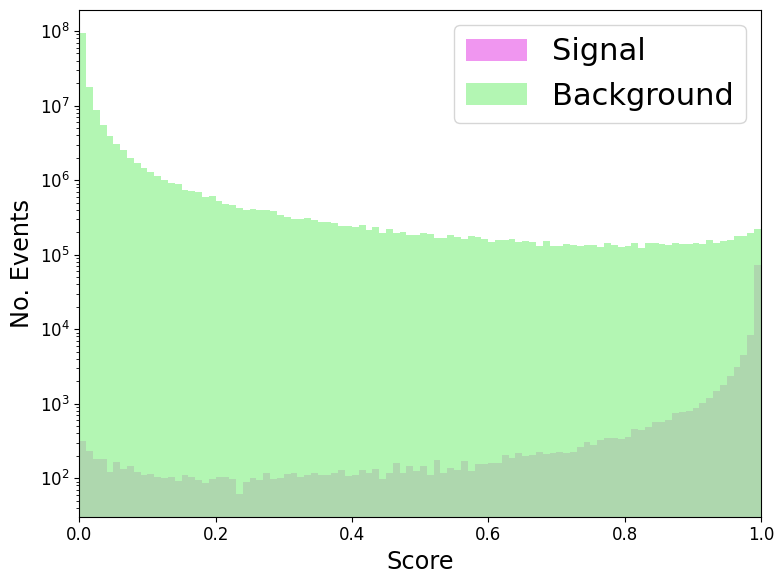

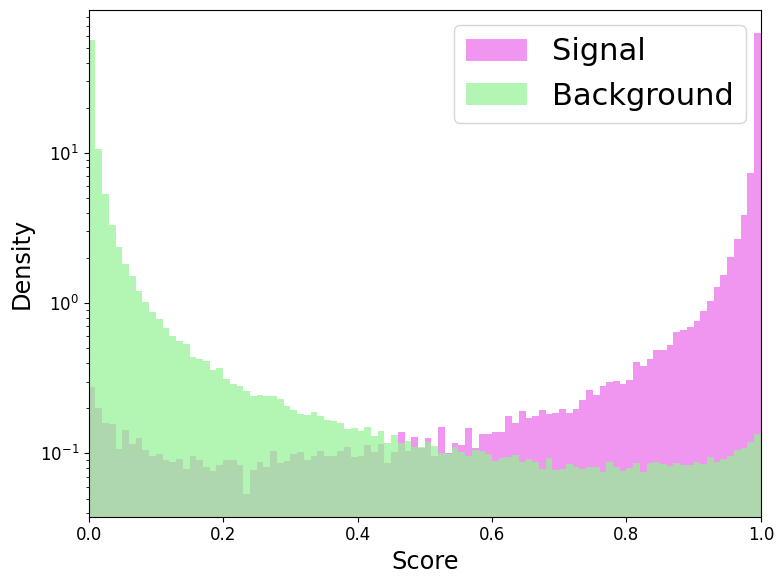

In [152]:
# Scaled Score Plot

plt.figure(figsize=(8, 6))
plt.yscale('log')
#bins=np.histogram(np.hstack((all_signal_probs ,all_background_probs)), bins=1000)[1] #get the bin edges
bins = np.linspace(0,1,101)
plt.hist(all_signal_probs, bins=bins, color='#ea6aea', alpha=0.7, label='Signal', weights=sig_scale)
plt.hist(all_background_probs, bins=bins, color='#93f393', alpha=0.7, label='Background', weights=ttb_scale)

plt.xlabel('Score',fontsize="x-large")
plt.ylabel('No. Events',fontsize="x-large")
plt.xlim(0,1)
plt.legend(loc='upper right')
plt.tight_layout()
#plt.savefig('ModelOutputDistDefault.png')
plt.savefig(f'Saved Figures/GATComplexNorm/kFold/CarlFold/84TeV/hadhad_Score_CarlFold_scaled.png')
plt.savefig(f'Saved Figures/GATComplexNorm/kFold/CarlFold/84TeV/hadhad_Score_CarlFold_scaled.pdf')
plt.show()

plt.figure(figsize=(8, 6))
plt.yscale('log')
#bins=np.histogram(np.hstack((all_signal_probs ,all_background_probs)), bins=1000)[1] #get the bin edges
bins = np.linspace(0,1,101)
plt.hist(all_signal_probs, bins=bins, color='#ea6aea', alpha=0.7, label='Signal', weights=sig_scale, density=True)
plt.hist(all_background_probs, bins=bins, color='#93f393', alpha=0.7, label='Background', weights=ttb_scale, density=True)

plt.xlabel('Score',fontsize="x-large")
plt.ylabel('Density',fontsize="x-large")
plt.xlim(0,1)
plt.legend(loc='upper right', fontsize=22)
plt.tight_layout()
#plt.savefig('ModelOutputDistDefault.png')
plt.savefig(f'Saved Figures/GATComplexNorm/kFold/CarlFold/84TeV/hadhad_Score_CarlFold_scaled_density.png')
plt.savefig(f'Saved Figures/GATComplexNorm/kFold/CarlFold/84TeV/hadhad_Score_CarlFold_scaled_density.pdf')
plt.show()

72380 213475


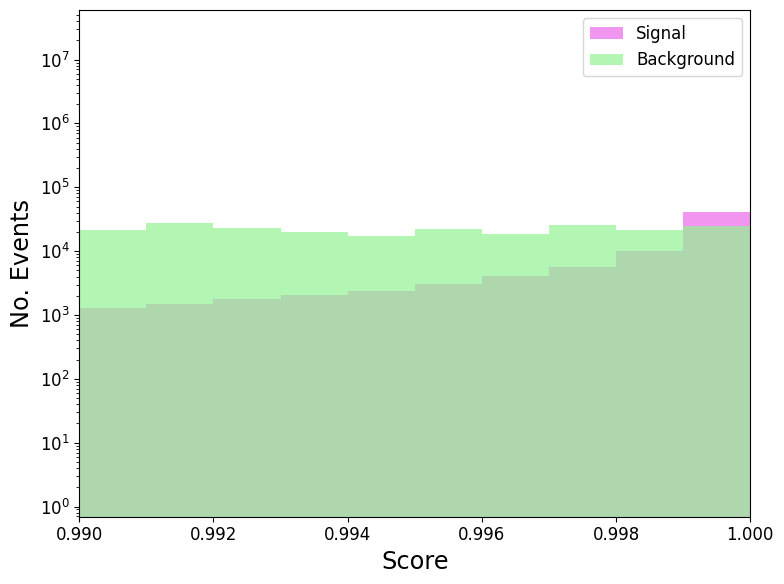

Signal bins (0.99-1.00) =  [ 1257.04475539  1279.32149789  1462.30902557  1780.54820415
  2086.05781559  2388.38503524  3047.1401349   4084.59985707
  5706.02847194 10226.61600367 40322.49512212]

Background bins (0.99-1.00) =  [15546.21101201 21764.69541681 27205.86927101 23319.31651804
 20210.07431561 17100.83211321 22542.00596741 18655.45321441
 25651.24816981 21764.69541681 24873.93761921]


In [132]:
# Plotting

print(len(all_signal_probs), len(all_background_probs))

plt.figure(figsize=(8, 6))
plt.yscale('log')
#bins=np.histogram(np.hstack((all_signal_probs ,all_background_probs)), bins=1000)[1] #get the bin edges
bins = np.linspace(0,1,1001)
plt.hist(all_signal_probs, bins=bins, color='#ea6aea', alpha=0.7, label='Signal', weights=sig_scale)
plt.hist(all_background_probs, bins=bins, color='#93f393', alpha=0.7, label='Background', weights=ttb_scale)

plt.xlabel('Score',fontsize="x-large")
plt.ylabel('No. Events',fontsize="x-large")
plt.xlim(0.99,1)
plt.legend(loc='upper right')
plt.tight_layout()
#plt.savefig('ModelOutputDistDefault.png')
plt.savefig(f'Saved Figures/GATComplexNorm/kFold/CarlFold/84TeV/hadhad_Score_CarlFold_scaled_zoom0.99.png')
plt.savefig(f'Saved Figures/GATComplexNorm/kFold/CarlFold/84TeV/hadhad_Score_CarlFold_scaled_zoom0.99.pdf')
plt.show()

print('Signal bins (0.99-1.00) = ',plt.hist(all_signal_probs, bins=bins, alpha=0.7, label='Signal', color='#ea6aea', weights=sig_scale)[0][989:])
print('')
print('Background bins (0.99-1.00) = ',plt.hist(all_background_probs, bins=bins, alpha=0.7, label='Background', color='#93f393', weights=ttb_scale)[0][989:])
plt.close()

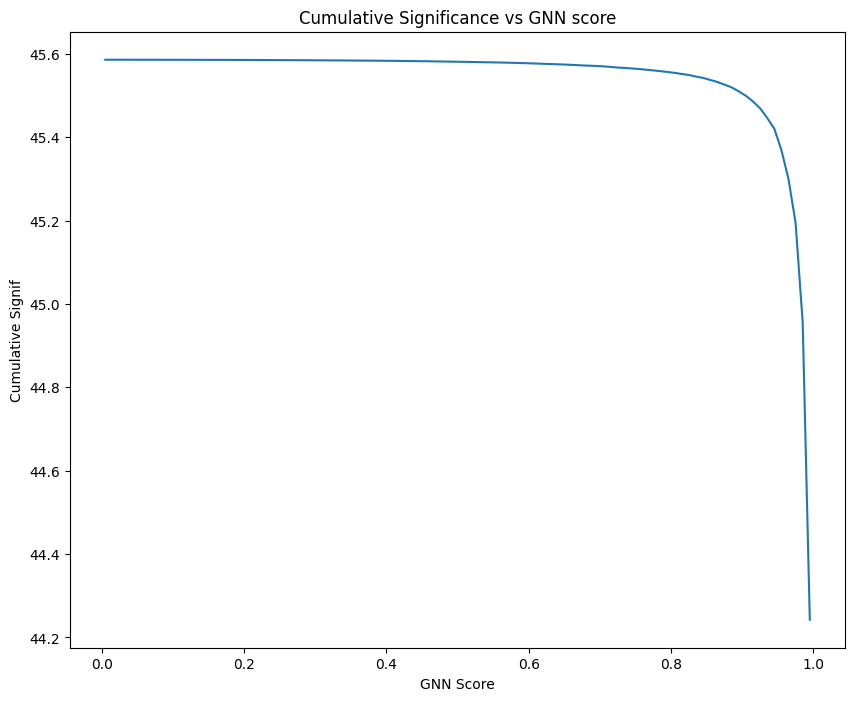

In [31]:
# Cumulative Signifiance

bins = np.linspace(0, 1.0, 101)

ns = plt.hist(all_signal_probs, bins=bins, alpha=0.7, label='Signal', color='#ea6aea', weights=sig_scale)[0]
nb = plt.hist(all_background_probs, bins=bins, alpha=0.7, label='Signal', color='#93f393', weights=ttb_scale)[0]

plt.close()
def cumul_signif(nsig, nbkg, bins): # Thank for this function Carl :)
    "Function to calculate cumulative signifiance"
    signif = 0
    signifs = []
    bincents = []

    # Loop over signal and background per bin from the right
    for (nsi, nbi) in zip(reversed(nsig), reversed(nbkg)):
        #print (nsi, nbi)
        # Sum significances in quadrature and store sqrt
        signif += (nsi/np.sqrt(nbi)) ** 2
        signifs.append(np.sqrt(signif))   
    
    # Reverse back to correct direction
    signifs = np.array(list(reversed(signifs)))

    # Find bin centres
    for i in range(len(bins[:-1])):
        #print(i, bins[i+1], bins[i])
        c = bins[i] + (bins[i+1] - bins[i])/2
        bincents.append(c) 
        
    return bincents, signifs

bincents, signifs = cumul_signif(ns, nb, bins) 

plt.figure(figsize=(10, 8))
plt.title("Cumulative Significance vs GNN score")
plt.xlabel("GNN Score")
plt.ylabel("Cumulative Signif")
plt.savefig(f'Saved Figures/Significance/84TeV/CumPerBinCumulativeSignificance_{save_bool}_{stats_string}_{EPOCH_NUMBER}Epochs.pdf')
plt.savefig(f'Saved Figures/Significance/84TeV/CumPerBinCumulativeSignificance_{save_bool}_{stats_string}_{EPOCH_NUMBER}Epochs.png')
plt.plot(bincents, signifs)
plt.show()

100
44.24240039147484


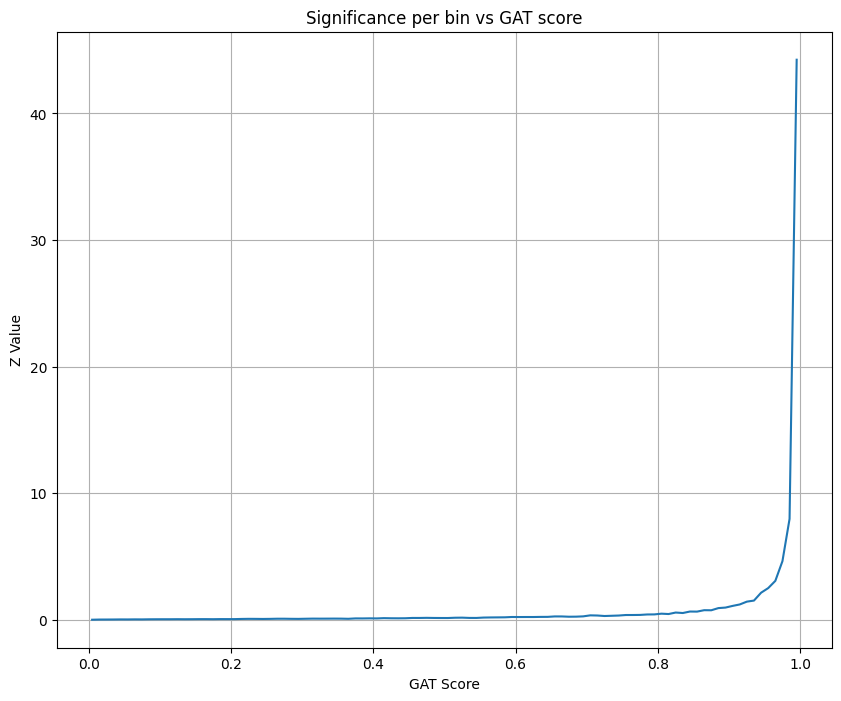

In [32]:
#calculating significance per bin:

data_bybin = list(zip(ns, nb)) #zipping up signal and background counts in each bin

def significance(s,b, syst_err = 0):
    z_val = s/np.sqrt(b + syst_err**2) 
    return z_val

Z_values = []
for i in range(len(data_bybin)): #for each bin
    Z_values.append(significance(data_bybin[i][0],data_bybin[i][1])) #calculating significance and appending to list

print(len(Z_values)) #as there is 50 bins, should be 50 Z values.
print(Z_values[len(Z_values)-1]) #last bin Z value

#Plotting using centre of each bin:
plt.figure(figsize=(10, 8))
plt.title("Significance per bin vs GAT score")
plt.plot(bincents, Z_values)
os.makedirs('Saved Figures/Significance', exist_ok=True)
plt.xlabel('GAT Score')
plt.ylabel('Z Value')
plt.grid()
plt.savefig(f'Saved Figures/Significance/PerBinSignificance_{save_bool}_{stats_string}_{EPOCH_NUMBER}Epochs.pdf')
plt.savefig(f'Saved Figures/Significance/PerBinSignificance_{save_bool}_{stats_string}_{EPOCH_NUMBER}Epochs.png')
plt.show()